In [ ]:
"""
fraud_detection_demo.py
Ví dụ: xây dựng mô hình phát hiện gian lận (fraud detection)
Chạy: python fraud_detection_demo.py
Yêu cầu: scikit-learn, pandas, numpy, matplotlib, joblib
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
RANDOM_SEED = 42

# ---------------------------
# 1) Tạo dữ liệu mô phỏng
# ---------------------------
def generate_synthetic_transactions(n_samples=20000, fraud_ratio=0.02, random_state=RANDOM_SEED):
    np.random.seed(random_state)
    n_fraud = int(n_samples * fraud_ratio)
    n_legit = n_samples - n_fraud

    # Cột cơ bản mô phỏng
    def make_group(n, is_fraud):
        # amount: fraud tends to have higher variance and occasionally larger amounts
        amount = np.concatenate([
            np.random.exponential(scale=50, size=int(n*0.9)),
            np.random.exponential(scale=500, size=int(n*0.1))
        ])[:n]
        if is_fraud:
            amount *= np.random.uniform(1.5, 5.0, size=n)

        # txn_hour: 0-23 (fraud might happen more at odd hours)
        txn_hour = np.random.randint(0, 24, size=n)
        if is_fraud:
            odd_hours = (txn_hour < 6) | (txn_hour > 22)
            txn_hour = np.where(np.random.rand(n) < 0.6, txn_hour, np.random.randint(0, 24, size=n))

        # ip_risk_score: 0-1 (higher -> suspicious)
        ip_risk_score = np.random.beta(1, 10, size=n)
        if is_fraud:
            ip_risk_score = np.clip(np.random.beta(3, 2, size=n), 0, 1)

        # device_trust: 0-1 low -> suspicious
        device_trust = np.random.beta(5, 1.5, size=n)
        if is_fraud:
            device_trust = np.clip(np.random.beta(1.5, 3, size=n), 0, 1)

        # user_history: number of prior transactions
        user_history_count = np.random.poisson(10, size=n)
        if is_fraud:
            user_history_count = np.random.poisson(1, size=n)

        # velocity: number of transactions in last hour for this (simulated) user
        velocity = np.random.poisson(0.5, size=n)
        if is_fraud:
            velocity = np.random.poisson(3, size=n)

        # is_new_card (0/1)
        is_new_card = np.random.binomial(1, 0.05, size=n)
        if is_fraud:
            is_new_card = np.random.binomial(1, 0.3, size=n)

        df = pd.DataFrame({
            "amount": amount,
            "txn_hour": txn_hour,
            "ip_risk_score": ip_risk_score,
            "device_trust": device_trust,
            "user_history_count": user_history_count,
            "velocity": velocity,
            "is_new_card": is_new_card,
        })
        return df

    df_legit = make_group(n_legit, is_fraud=False)
    df_fraud = make_group(n_fraud, is_fraud=True)
    df = pd.concat([df_legit, df_fraud], ignore_index=True)
    df["is_fraud"] = 0
    df.loc[df.index[-n_fraud:], "is_fraud"] = 1

    # shuffle
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

df = generate_synthetic_transactions(n_samples=50000, fraud_ratio=0.015)  # 1.5% fraud
print("Dữ liệu mô phỏng:\n", df.head())
print(df["is_fraud"].value_counts(normalize=True))

# ---------------------------
# 2) Feature engineering cơ bản
# ---------------------------
# Thêm một vài feature derived đơn giản
df["amount_log"] = np.log1p(df["amount"])
df["txn_is_night"] = ((df["txn_hour"] < 6) | (df["txn_hour"] > 22)).astype(int)
# ratio: amount / (1 + user_history_count)
df["amount_per_history"] = df["amount"] / (1 + df["user_history_count"])

features = [
    "amount", "amount_log", "txn_hour", "txn_is_night",
    "ip_risk_score", "device_trust", "user_history_count",
    "velocity", "is_new_card", "amount_per_history",
]
X = df[features]
y = df["is_fraud"]

# ---------------------------
# 3) Train/test split (stratified)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# ---------------------------
# 4) Pipeline: scaling + model
# ---------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",     # quan trọng khi unbalanced
        random_state=RANDOM_SEED,
        n_jobs=-1
    )),
])

# ---------------------------
# 5) Hyperparam search (nhỏ) -- optional
# ---------------------------
param_grid = {
    "clf__max_depth": [6, 10],
    "clf__min_samples_split": [2, 8],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
search = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
best_model = search.best_estimator_

# ---------------------------
# 6) Đánh giá trên test set
# ---------------------------
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)   # threshold mặc định 0.5 — có thể điều chỉnh

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Precision-Recall curve + AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC (AUPRC): {pr_auc:.4f}")

# ---------------------------
# 7) Vẽ PR curve và ROC curve
# ---------------------------
def plot_pr_curve(recall, precision, pr_auc):
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_scores, roc_auc):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pr_curve(recall, precision, pr_auc)
plot_roc(y_test, y_pred_proba, roc_auc)

# ---------------------------
# 8) Tuning threshold (ví dụ)
# ---------------------------
# Khi business muốn ưu tiên recall (bắt fraud nhiều hơn), ta giảm threshold.
def evaluate_at_threshold(th):
    pred = (y_pred_proba >= th).astype(int)
    rep = classification_report(y_test, pred, digits=4, output_dict=True)
    return rep

for th in [0.9, 0.7, 0.5, 0.3, 0.2]:
    rep = evaluate_at_threshold(th)
    print(f"\nThreshold {th}: precision={rep['1']['precision']:.4f}, recall={rep['1']['recall']:.4f}, f1={rep['1']['f1-score']:.4f}")

# ---------------------------
# 9) Lưu model để dùng production (pickle / joblib)
# ---------------------------
model_path = "fraud_detector_rf.joblib"
joblib.dump(best_model, model_path)
print(f"\nĐã lưu model tại: {model_path}")

# ---------------------------
# 10) Ví dụ scoring realtime (demo)
# ---------------------------
def score_transaction(model, txn: dict):
    # txn: dict chứa các feature tương ứng
    df_txn = pd.DataFrame([txn])
    # tạo các feature derived giống pipeline
    df_txn["amount_log"] = np.log1p(df_txn["amount"])
    df_txn["txn_is_night"] = ((df_txn["txn_hour"] < 6) | (df_txn["txn_hour"] > 22)).astype(int)
    df_txn["amount_per_history"] = df_txn["amount"] / (1 + df_txn["user_history_count"])
    X_txn = df_txn[features]
    prob = model.predict_proba(X_txn)[:, 1][0]
    return prob

loaded = joblib.load(model_path)
sample_txn = {
    "amount": 1200.0,
    "txn_hour": 2,
    "ip_risk_score": 0.8,
    "device_trust": 0.2,
    "user_history_count": 0,
    "velocity": 5,
    "is_new_card": 1,
    # amount_log, txn_is_night, amount_per_history will be derived inside function
}
score = score_transaction(loaded, sample_txn)
print(f"\nScore nguy cơ gian lận cho transaction sample: {score:.4f} (0..1)")

# ---------------------------
# Lưu ý / next steps
# ---------------------------
print("""
Lưu ý thực tế:
- Dùng dataset thật (có label chính xác) thay cho dữ liệu mô phỏng.
- Cân nhắc imbalance: dùng SMOTE / undersampling / class_weight nếu cần.
- Theo dõi drift (concept/data drift) -> tái huấn luyện định kỳ.
- Triển khai realtime: expose model qua REST/gRPC, tính latency, feature store.
- Thử nhiều mô hình khác: XGBoost/LightGBM thường rất mạnh trên tabular data.
""")


In [2]:
import numpy as np
import pandas as pd

def generate_synthetic_transactions(n_samples=20000, fraud_ratio=0.02, random_state=42):
    np.random.seed(random_state)
    n_fraud = int(n_samples * fraud_ratio)
    n_legit = n_samples - n_fraud

    def make_group(n, is_fraud):
        # amount
        amount = np.concatenate([
            np.random.exponential(scale=50, size=int(n*0.9)),
            np.random.exponential(scale=500, size=int(n*0.1))
        ])[:n]
        if is_fraud:
            amount *= np.random.uniform(1.5, 5.0, size=n)

        # hour of transaction
        txn_hour = np.random.randint(0, 24, size=n)
        if is_fraud:
            txn_hour = np.where(np.random.rand(n) < 0.6, np.random.randint(0, 24, size=n), txn_hour)

        # ip risk score
        ip_risk_score = np.random.beta(1, 10, size=n)
        if is_fraud:
            ip_risk_score = np.random.beta(3, 2, size=n)

        # device trust
        device_trust = np.random.beta(5, 1.5, size=n)
        if is_fraud:
            device_trust = np.random.beta(1.5, 3, size=n)

        # user history
        user_history_count = np.random.poisson(10, size=n)
        if is_fraud:
            user_history_count = np.random.poisson(1, size=n)

        # velocity (transactions/hour)
        velocity = np.random.poisson(0.5, size=n)
        if is_fraud:
            velocity = np.random.poisson(3, size=n)

        # is_new_card
        is_new_card = np.random.binomial(1, 0.05, size=n)
        if is_fraud:
            is_new_card = np.random.binomial(1, 0.3, size=n)

        df = pd.DataFrame({
            "amount": amount,
            "txn_hour": txn_hour,
            "ip_risk_score": ip_risk_score,
            "device_trust": device_trust,
            "user_history_count": user_history_count,
            "velocity": velocity,
            "is_new_card": is_new_card
        })
        return df

    df_legit = make_group(n_legit, is_fraud=False)
    df_fraud = make_group(n_fraud, is_fraud=True)
    df = pd.concat([df_legit, df_fraud], ignore_index=True)
    df["is_fraud"] = 0
    df.loc[df.index[-n_fraud:], "is_fraud"] = 1

    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

# Sinh dữ liệu
df = generate_synthetic_transactions(n_samples=50000, fraud_ratio=0.015)

# Lưu ra file CSV
output_file = "fraud_detection.csv"
df.to_csv(output_file, index=False)
print(f"✅ Đã lưu dataset {output_file} với {df.shape[0]} dòng, {df.shape[1]} cột")
print(df.head())


✅ Đã lưu dataset fraud_detection.csv với 50000 dòng, 8 cột
       amount  txn_hour  ip_risk_score  device_trust  user_history_count  \
0   16.406188         0       0.135009      0.895042                   9   
1   92.962184         5       0.180288      0.433857                   8   
2   75.678110         5       0.165082      0.911437                   8   
3  319.060603        14       0.163748      0.781367                   8   
4   46.497766        16       0.140344      0.611271                   7   

   velocity  is_new_card  is_fraud  
0         1            0         0  
1         1            0         0  
2         1            0         0  
3         0            0         0  
4         0            0         0  


Dataset shape: (50000, 8)
       amount  txn_hour  ip_risk_score  device_trust  user_history_count  \
0   16.406188         0       0.135009      0.895042                   9   
1   92.962184         5       0.180288      0.433857                   8   
2   75.678110         5       0.165082      0.911437                   8   
3  319.060603        14       0.163748      0.781367                   8   
4   46.497766        16       0.140344      0.611271                   7   

   velocity  is_new_card  is_fraud  
0         1            0         0  
1         1            0         0  
2         1            0         0  
3         0            0         0  
4         0            0         0  
Train size: (37500, 7) Test size: (12500, 7)

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     12313
           1     0.9891    0.9733    0.9811       187

    accuracy                         0.9994     12500
 

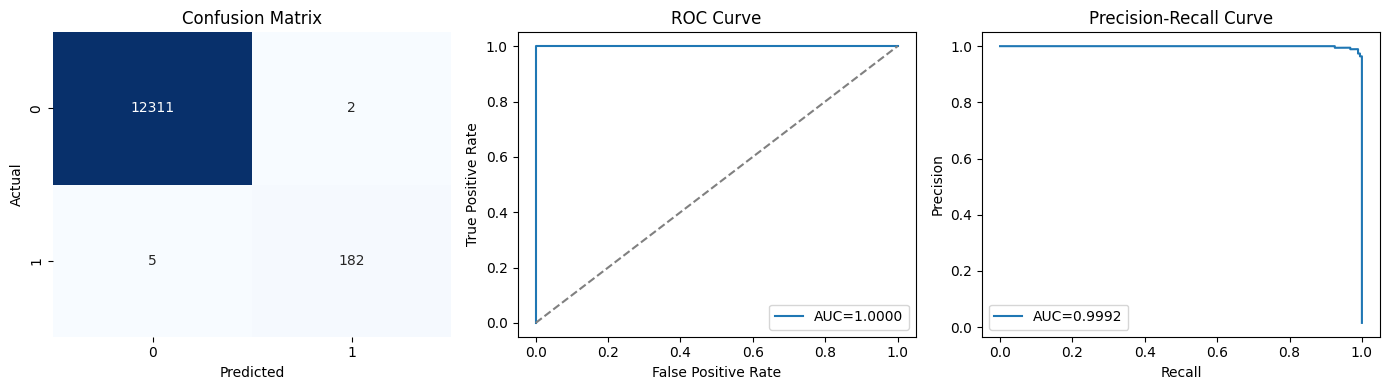

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# Thử import XGBoost, nếu không có thì dùng RandomForest
try:
    from xgboost import XGBClassifier
    use_xgb = True
except ImportError:
    from sklearn.ensemble import RandomForestClassifier
    use_xgb = False

# 1. Đọc dữ liệu
df = pd.read_csv("fraud_detection.csv")
print("Dataset shape:", df.shape)
print(df.head())

# 2. Chia features và label
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# 4. Huấn luyện mô hình
if use_xgb:
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"
    )
else:
    model = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

model.fit(X_train, y_train)

# 5. Dự đoán
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# 6. Đánh giá
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

# 7. Visualization
plt.figure(figsize=(14,4))

# Confusion Matrix
plt.subplot(1,3,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# ROC Curve
plt.subplot(1,3,2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"AUC={pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


Dataset shape: (50000, 8)
       amount  txn_hour  ip_risk_score  device_trust  user_history_count  \
0   16.406188         0       0.135009      0.895042                   9   
1   92.962184         5       0.180288      0.433857                   8   
2   75.678110         5       0.165082      0.911437                   8   
3  319.060603        14       0.163748      0.781367                   8   
4   46.497766        16       0.140344      0.611271                   7   

   velocity  is_new_card  is_fraud  
0         1            0         0  
1         1            0         0  
2         1            0         0  
3         0            0         0  
4         0            0         0  

=== RandomForest Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     12313
           1     0.9891    0.9733    0.9811       187

    accuracy                         0.9994     12500
   macro avg     0.9944    0.9865    0.9904     

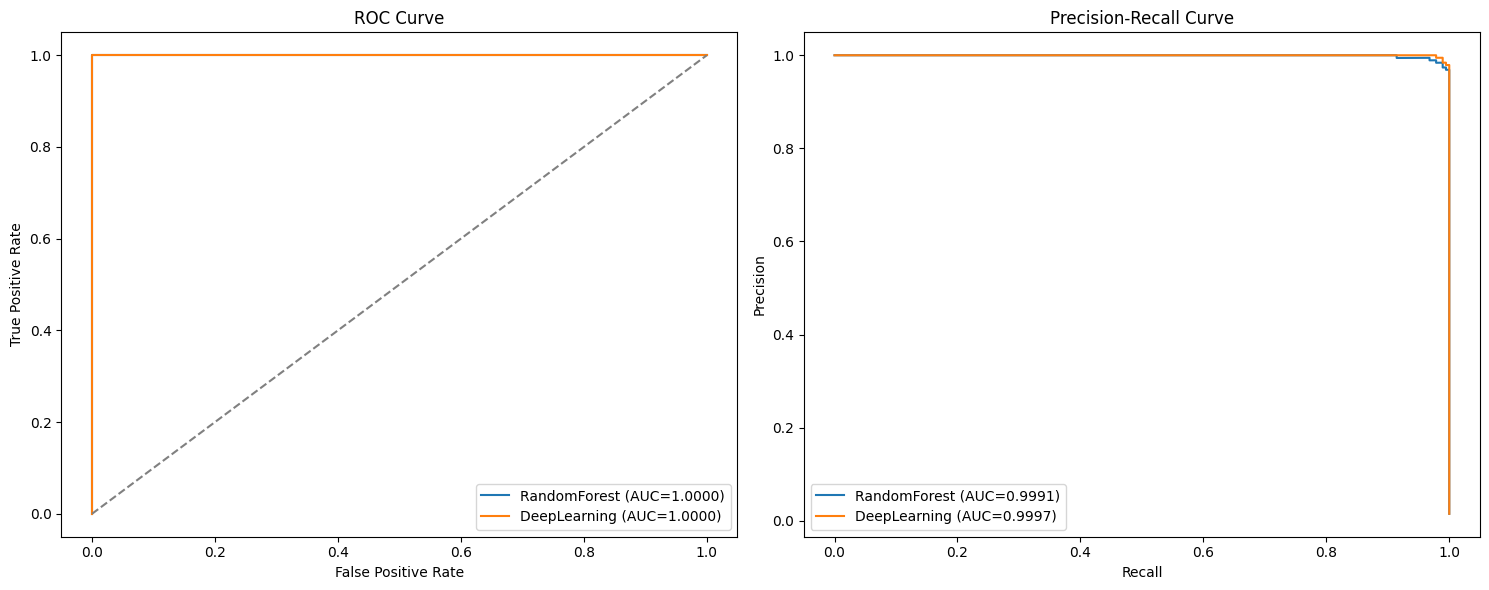

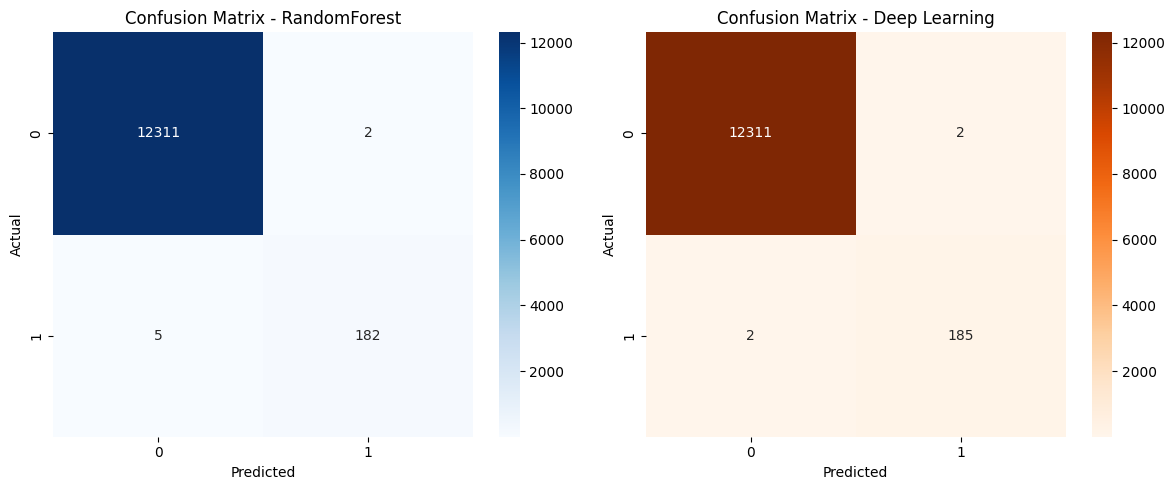


=== So sánh các Metric ===
              Accuracy  Precision    Recall  F1-score
RandomForest   0.99944   0.989130  0.973262  0.981132
DeepLearning   0.99968   0.989305  0.989305  0.989305


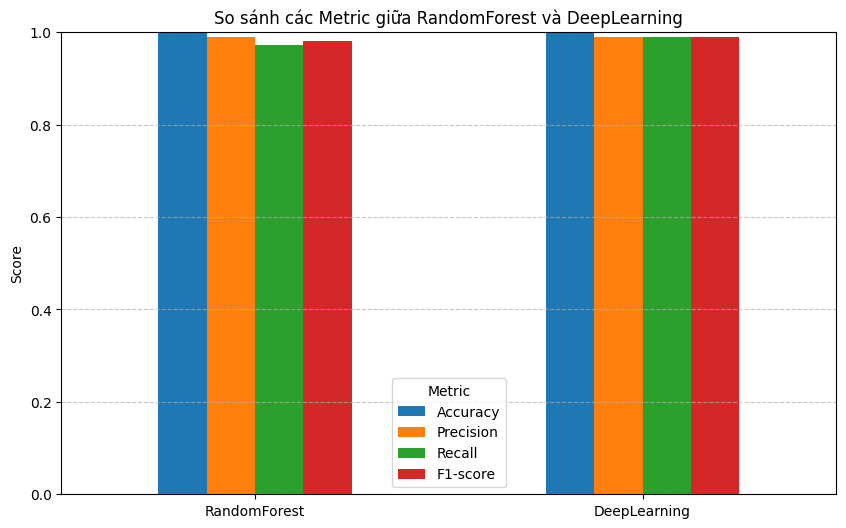

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("fraud_detection.csv")
print("Dataset shape:", df.shape)
print(df.head())

X = df.drop(columns=["is_fraud"]).values
y = df["is_fraud"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale data cho DL
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 2. Machine Learning Model
# =========================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== RandomForest Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

# =========================
# 3. Deep Learning Model
# =========================
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

es = EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

y_proba_dl = model.predict(X_test_scaled).ravel()
y_pred_dl = (y_proba_dl >= 0.5).astype(int)

print("\n=== Deep Learning Report ===")
print(classification_report(y_test, y_pred_dl, digits=4))

roc_auc_dl = roc_auc_score(y_test, y_proba_dl)
precision_dl, recall_dl, _ = precision_recall_curve(y_test, y_proba_dl)
pr_auc_dl = auc(recall_dl, precision_dl)

# =========================
# 4. Visualization
# =========================
plt.figure(figsize=(15,6))

# --- ROC Curve ---
plt.subplot(1,2,1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_proba_dl)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_rf:.4f})")
plt.plot(fpr_dl, tpr_dl, label=f"DeepLearning (AUC={roc_auc_dl:.4f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# --- Precision-Recall Curve ---
plt.subplot(1,2,2)
plt.plot(recall_rf, precision_rf, label=f"RandomForest (AUC={pr_auc_rf:.4f})")
plt.plot(recall_dl, precision_dl, label=f"DeepLearning (AUC={pr_auc_dl:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

# =========================
# 5. Confusion Matrix
# =========================
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_dl = confusion_matrix(y_test, y_pred_dl)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - RandomForest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Confusion Matrix - Deep Learning")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =========================
# 6. Tổng hợp Metric
# =========================
metrics = {
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dl)
    ],
    "Precision": [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_dl)
    ],
    "Recall": [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_dl)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_dl)
    ]
}

metrics_df = pd.DataFrame(metrics, index=["RandomForest", "DeepLearning"])
print("\n=== So sánh các Metric ===")
print(metrics_df)

# =========================
# 7. Visualization Metric
# =========================
metrics_df.plot(kind="bar", figsize=(10,6))
plt.title("So sánh các Metric giữa RandomForest và DeepLearning")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



Dataset shape: (50000, 8)
       amount  txn_hour  ip_risk_score  device_trust  user_history_count  \
0   16.406188         0       0.135009      0.895042                   9   
1   92.962184         5       0.180288      0.433857                   8   
2   75.678110         5       0.165082      0.911437                   8   
3  319.060603        14       0.163748      0.781367                   8   
4   46.497766        16       0.140344      0.611271                   7   

   velocity  is_new_card  is_fraud  
0         1            0         0  
1         1            0         0  
2         1            0         0  
3         0            0         0  
4         0            0         0  

=== RandomForest Report ===
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     12313
           1     0.9891    0.9733    0.9811       187

    accuracy                         0.9994     12500
   macro avg     0.9944    0.9865    0.9904     

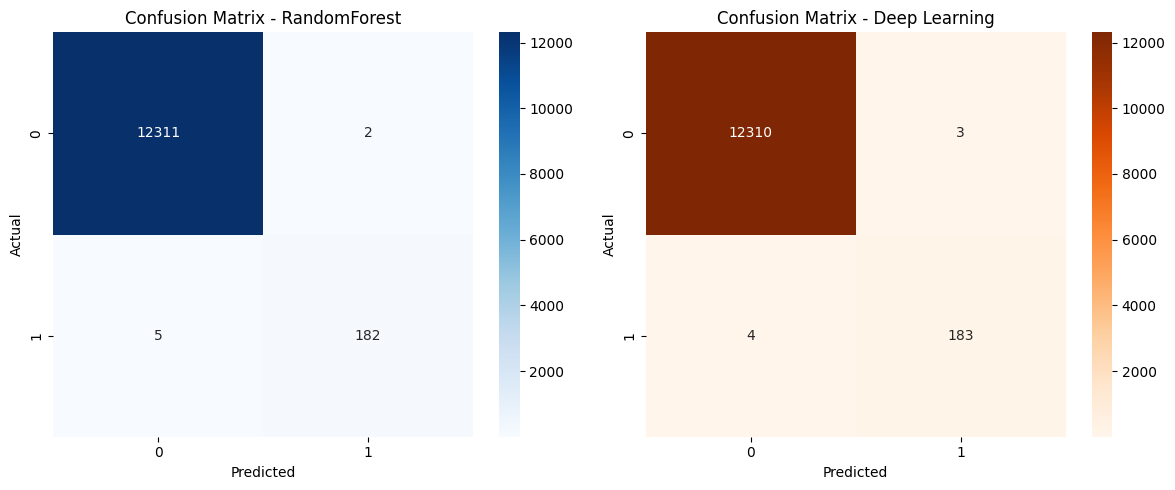


=== So sánh các Metric ===
              Accuracy  Precision    Recall  F1-score
RandomForest   0.99944   0.989130  0.973262  0.981132
DeepLearning   0.99944   0.983871  0.978610  0.981233


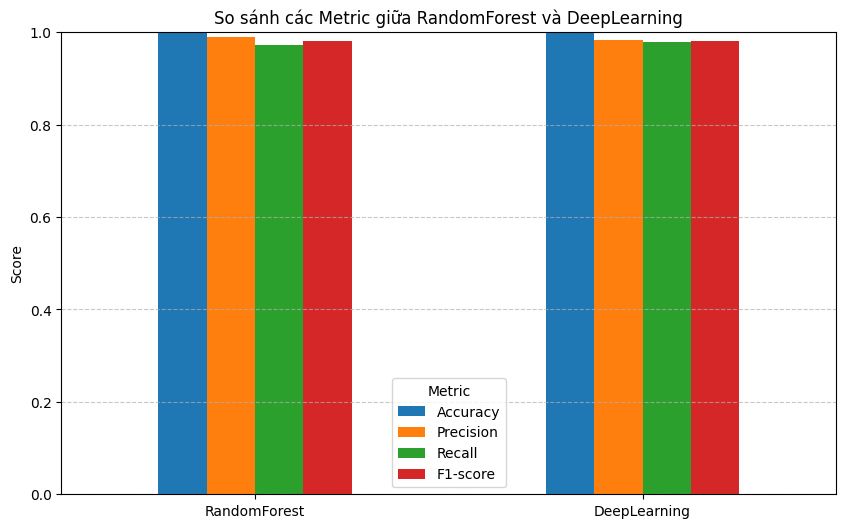

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("fraud_detection.csv")
print("Dataset shape:", df.shape)
print(df.head())

X = df.drop(columns=["is_fraud"]).values
y = df["is_fraud"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale data cho DL
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 2. Machine Learning Model
# =========================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n=== RandomForest Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))

# =========================
# 3. Deep Learning Model
# =========================
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

es = EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

y_proba_dl = model.predict(X_test_scaled).ravel()
y_pred_dl = (y_proba_dl >= 0.5).astype(int)

print("\n=== Deep Learning Report ===")
print(classification_report(y_test, y_pred_dl, digits=4))

# =========================
# 4. Confusion Matrix
# =========================
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_dl = confusion_matrix(y_test, y_pred_dl)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - RandomForest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("Confusion Matrix - Deep Learning")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# =========================
# 5. Tổng hợp Metric
# =========================
metrics = {
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_dl)
    ],
    "Precision": [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_dl)
    ],
    "Recall": [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_dl)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_dl)
    ]
}

metrics_df = pd.DataFrame(metrics, index=["RandomForest", "DeepLearning"])
print("\n=== So sánh các Metric ===")
print(metrics_df)

# =========================
# 6. Visualization Metric
# =========================
metrics_df.plot(kind="bar", figsize=(10,6))
plt.title("So sánh các Metric giữa RandomForest và DeepLearning")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
